# Part 1: RNN models with LSTM

In [382]:
# Dataset
# In this case, we are going to use one stock of the Chinese stock market, u may need to install the api package first
# pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn
import baostock as bs
import pandas as pd

#### Login to baostock api ####
lg = bs.login()
# display feedback of login
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### Get stock history of A-share of mainland China  ####
rs = bs.query_history_k_data_plus("sz.002838",#change the specific stock ID in the quotation mark
    "date,open,high,low,close,volume",
    start_date='2000-01-01', end_date='2020-04-22', #change the period that we want to aquire the daily data
    frequency="d", adjustflag="3") 
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### Output the dataset ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # Request each entry and append them
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
#### Save the data as csv ####
result.to_csv("history_k_data.csv", encoding="gbk", index=False)
print(result)

#### Logout from baostock api ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
           date     open     high      low    close    volume
0    2017-01-06  18.3400  22.0000  18.3400  22.0000      7021
1    2017-01-09  24.2000  24.2000  24.2000  24.2000      2721
2    2017-01-10  26.6200  26.6200  26.6200  26.6200      2000
3    2017-01-11  29.2800  29.2800  29.2800  29.2800      6200
4    2017-01-12  32.2100  32.2100  32.2100  32.2100      6921
..          ...      ...      ...      ...      ...       ...
796  2020-04-16  40.6900  41.4500  38.7000  39.2500  28623287
797  2020-04-17  39.5000  39.9100  37.8000  38.2800  25541813
798  2020-04-20  37.8100  39.0800  36.7100  38.6400  24013819
799  2020-04-21  38.3400  41.1300  37.8300  38.7200  28839858
800  2020-04-22  38.0300  39.2000  37.2600  38.1000  16671958

[801 rows x 6 columns]
logout success!


In [383]:
# Data processing
import pandas as pd
from sklearn import preprocessing
import numpy as np

# Preliminary settings
# The number of days of stock history the model gets to base its predictions off of
history_points = 30

# Normalise the data — scale it between 0 and 1
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)
    
    data = data.values
    
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])

    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)
    
    next_day_high_values_normalised = np.array([data_normalised[:, 1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_high_values_normalised = np.expand_dims(next_day_high_values_normalised, -1)
    next_day_high_values = np.array([data[:, 1][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_high_values = np.expand_dims(next_day_high_values, -1)

    next_day_low_values_normalised = np.array([data_normalised[:, 2][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_low_values_normalised = np.expand_dims(next_day_low_values_normalised, -1)
    next_day_low_values = np.array([data[:, 2][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_low_values = np.expand_dims(next_day_low_values, -1)
    
    next_day_close_values_normalised = np.array([data_normalised[:, 3][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_close_values_normalised = np.expand_dims(next_day_close_values_normalised, -1)
    next_day_close_values = np.array([data[:, 3][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)
    
    y_normaliser = preprocessing.MinMaxScaler()
    y_open = y_normaliser.fit(next_day_open_values)
    y_high = y_normaliser.fit(next_day_high_values)
    y_low = y_normaliser.fit(next_day_low_values)
    y_close = y_normaliser.fit(next_day_close_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
#         technical_indicators.append(np.array([sma]))
        technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
    

    def calculate_x_day_average(history_points,column):
        average_x_day_price = []    
        for i in range(len(data_normalised) - history_points):
            average_x_day_price.append(data_normalised[:,column][i:i+history_points].mean())       
        return average_x_day_price

    a = calculate_x_day_average(history_points,0)
    b = calculate_x_day_average(history_points,1)
    c = calculate_x_day_average(history_points,2)
    d = calculate_x_day_average(history_points,3)
    x_day_mean_indicator = np.array([a,b,c,d]).T
    
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] \
    == next_day_high_values_normalised.shape[0] == next_day_low_values_normalised.shape[0] \
    == next_day_close_values_normalised.shape[0] == technical_indicators_normalised.shape[0] == x_day_mean_indicator.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, \
    next_day_open_values_normalised, next_day_open_values, \
    next_day_high_values_normalised, next_day_high_values, \
    next_day_low_values_normalised, next_day_low_values, \
    next_day_close_values_normalised, next_day_close_values, x_day_mean_indicator, \
    y_open, y_high, y_low, y_close



# Use past prices as input only

In [384]:
# Get the dataset we have the csv file
ohlcv_histories_normalised, technical_indicators_normalised, \
    next_day_open_values_normalised, next_day_open_values, \
    next_day_high_values_normalised, next_day_high_values, \
    next_day_low_values_normalised, next_day_low_values, \
    next_day_close_values_normalised, next_day_close_values, x_day_mean_indicator, \
    y_open, y_high, y_low, y_close = csv_to_dataset('history_k_data.csv')

test_split = 0.9 # the percent of data to be used for training
n = int(ohlcv_histories_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]
# y_train = next_day_high_values_normalised[:n]
# y_train = next_day_low_values_normalised[:n]
# y_train = next_day_close_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]
# y_test = next_day_high_values_normalised[n:]
# y_test = next_day_low_values_normalised[n:]
# y_test = next_day_close_values_normalised[n:]


unscaled_y_test = next_day_open_values[n:]
# unscaled_y_test = next_day_high_values[n:]
# unscaled_y_test = next_day_low_values[n:]
# unscaled_y_test = next_day_close_values[n:]

print(ohlcv_train.shape, y_train.shape)
print(ohlcv_test.shape, y_test.shape)

(693, 30, 5) (693, 1)
(77, 30, 5) (77, 1)


In [385]:
# pip install keras
# pip install tensorflow
# conda install GraphViz --channel conda-forge -y

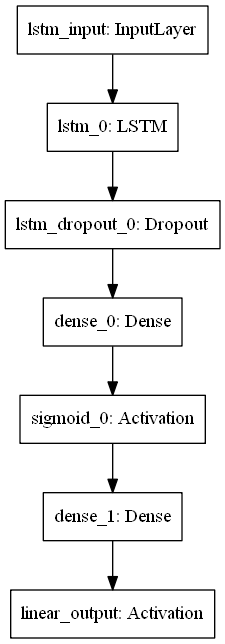

In [386]:
# Model

# basic model
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow as  tf
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(16, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.01)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'  # path of graphviz installed (https://www.graphviz.org/)
plot_model(model, to_file='model.png')



In [387]:
# Training
# fit the model
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)

Train on 623 samples, validate on 70 samples
Epoch 1/50
623/623 [==============================] - 1s 2ms/step - loss: 0.0375 - val_loss: 6.3063e-04
Epoch 2/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 3/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 8.1723e-05
Epoch 4/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 1.9529e-05
Epoch 5/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 2.7174e-05
Epoch 6/50
623/623 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 4.2440e-04
Epoch 7/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 1.3117e-05
Epoch 8/50
623/623 [==============================] - 1s 886us/step - loss: 0.0015 - val_loss: 2.9511e-05
Epoch 9/50
623/623 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 2.3227e-05
Epoch 10/50
623/623 [

In [388]:
# Evaluation

y_test_predicted = model.predict(ohlcv_test)
# model.predict returns normalised values
# now we scale them back up using the y_normaliser from before
y_test_predicted = y_open.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(ohlcv_histories_normalised)
y_predicted = y_open.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


11.329398258820794


In [389]:
# import matplotlib.pyplot as plt
# plt.gcf().set_size_inches(22, 15, forward=True)

# start = 0
# end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

# plt.legend(['Real', 'Predicted'])

# plt.show()

In [390]:
print(unscaled_y_test[-1])
print(y_test_predicted[-1])

[38.03]
[38.83183]


# Use past prices and 2 technical indicators as input

In [391]:
# Get the dataset we have the csv file
ohlcv_histories_normalised, technical_indicators_normalised, \
    next_day_open_values_normalised, next_day_open_values, \
    next_day_high_values_normalised, next_day_high_values, \
    next_day_low_values_normalised, next_day_low_values, \
    next_day_close_values_normalised, next_day_close_values, x_day_mean_indicator, \
    y_open, y_high, y_low, y_close = csv_to_dataset('history_k_data.csv')

test_split = 0.9 # the percent of data to be used for training
n = int(ohlcv_histories_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]
# y_train = next_day_high_values_normalised[:n]
# y_train = next_day_low_values_normalised[:n]
# y_train = next_day_close_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]
# y_test = next_day_high_values_normalised[n:]
# y_test = next_day_low_values_normalised[n:]
# y_test = next_day_close_values_normalised[n:]


unscaled_y_test = next_day_open_values[n:]
# unscaled_y_test = next_day_high_values[n:]
# unscaled_y_test = next_day_low_values[n:]
# unscaled_y_test = next_day_close_values[n:]


tech_ind_train = technical_indicators_normalised[:n]
tech_ind_test = technical_indicators_normalised[n:]


print(ohlcv_train.shape)
print(ohlcv_test.shape)
print(unscaled_y_test.shape)
print(tech_ind_train.shape)
print(tech_ind_test.shape)

(693, 30, 5)
(77, 30, 5)
(77, 1)
(693, 2)
(77, 2)


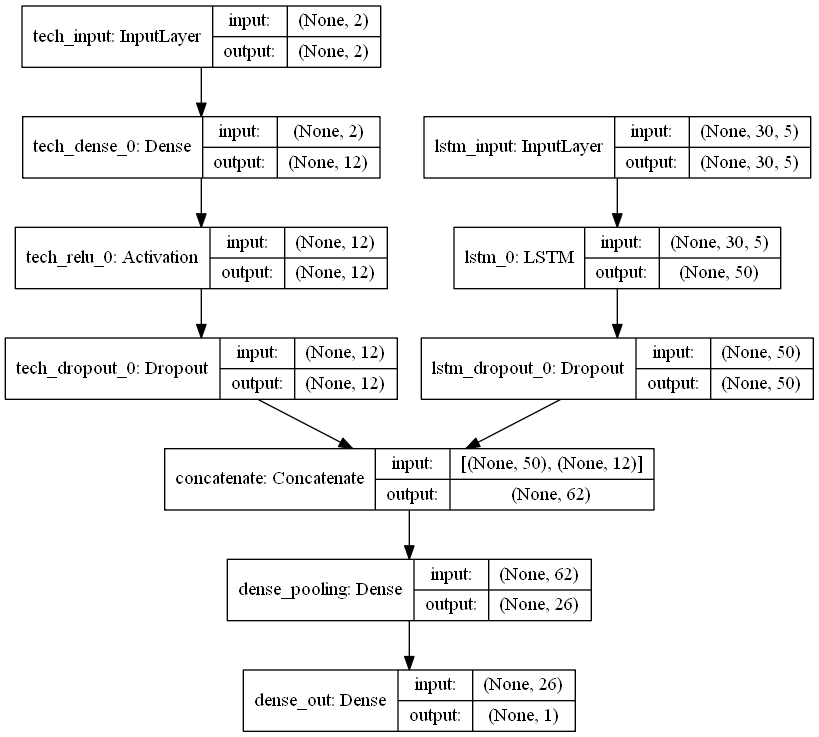

In [392]:
# Improved model including the technical indicators
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow as  tf
tf.random.set_seed(4)

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators_normalised.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(12, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(26, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.01)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'  # path of graphviz installed (https://www.graphviz.org/)
plot_model(model, to_file='model.png', show_shapes=True)

In [393]:
# Training
# fit the model
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

Train on 623 samples, validate on 70 samples
Epoch 1/50
623/623 [==============================] - 1s 2ms/step - loss: 0.0514 - val_loss: 0.0024
Epoch 2/50
623/623 [==============================] - 0s 541us/step - loss: 0.0063 - val_loss: 3.1549e-05
Epoch 3/50
623/623 [==============================] - 0s 504us/step - loss: 0.0027 - val_loss: 2.8049e-04
Epoch 4/50
623/623 [==============================] - 0s 565us/step - loss: 0.0021 - val_loss: 2.8244e-04
Epoch 5/50
623/623 [==============================] - 0s 589us/step - loss: 0.0018 - val_loss: 1.0311e-04
Epoch 6/50
623/623 [==============================] - 0s 613us/step - loss: 0.0020 - val_loss: 7.2389e-05
Epoch 7/50
623/623 [==============================] - 0s 588us/step - loss: 0.0022 - val_loss: 1.3799e-04
Epoch 8/50
623/623 [==============================] - 1s 941us/step - loss: 0.0019 - val_loss: 5.9030e-05
Epoch 9/50
623/623 [==============================] - 0s 604us/step - loss: 0.0017 - val_loss: 3.3317e-04
Epoch 1

In [394]:
# Evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
# model.predict returns normalised values
# now we scale them back up using the y_normaliser from before
y_test_predicted = y_open.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict([ohlcv_histories_normalised, technical_indicators_normalised])
y_predicted = y_open.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


11.051383820113017


In [395]:
print(unscaled_y_test[-1])
print(y_test_predicted[-1])

[38.03]
[38.649513]


In [396]:
# import matplotlib.pyplot as plt
# plt.gcf().set_size_inches(22, 15, forward=True)

# start = 0
# end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

# plt.legend(['Real', 'Predicted'])

# plt.show()

# Part 2: Calculate the correlation coefficients between x-days average prices and the next-day prices - example with the specific stock "sz.002838"

In [397]:
# Dataset
# In this case, we are going to use one stock of the Chinese stock market, u may need to install the api package first
# pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn
import baostock as bs
import pandas as pd

#### Login to baostock api ####
lg = bs.login()
# display feedback of login
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### Get stock history of A-share of mainland China  ####
rs = bs.query_history_k_data_plus("sz.002838",#change the specific stock ID in the quotation mark
    "date,open,high,low,close,volume",
    start_date='2000-01-01', end_date='2020-04-22', #change the period that we want to aquire the daily data
    frequency="d", adjustflag="3") 
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### Output the dataset ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # Request each entry and append them
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
#### Save the data as csv ####
result.to_csv("history_k_data.csv", encoding="gbk", index=False)
print(result)

#### Logout from baostock api ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
           date     open     high      low    close    volume
0    2017-01-06  18.3400  22.0000  18.3400  22.0000      7021
1    2017-01-09  24.2000  24.2000  24.2000  24.2000      2721
2    2017-01-10  26.6200  26.6200  26.6200  26.6200      2000
3    2017-01-11  29.2800  29.2800  29.2800  29.2800      6200
4    2017-01-12  32.2100  32.2100  32.2100  32.2100      6921
..          ...      ...      ...      ...      ...       ...
796  2020-04-16  40.6900  41.4500  38.7000  39.2500  28623287
797  2020-04-17  39.5000  39.9100  37.8000  38.2800  25541813
798  2020-04-20  37.8100  39.0800  36.7100  38.6400  24013819
799  2020-04-21  38.3400  41.1300  37.8300  38.7200  28839858
800  2020-04-22  38.0300  39.2000  37.2600  38.1000  16671958

[801 rows x 6 columns]
logout success!


In [398]:
import pandas as pd
import numpy as np

df = pd.read_csv('history_k_data.csv')
df = df.drop(0, axis=0)
def calculate_x_day_average(number_of_days, column_name):
    average_x_day = []
    
    for i in range(len(df[column_name])-number_of_days):
        average_x_day.append(df[column_name][i:i+number_of_days].mean())
        
    return average_x_day

def get_next_day_value(number_of_days, column_name):
    next_day_value = df[column_name][number_of_days:]
    
    return list(next_day_value)

In [399]:
days = [5,10,20,30,50]
column_mean = ['open','high','low','close','volume']
column_next_price = ['open','high','low','close']
ls1 = [(x,y) for x in days for y in column_mean]
ls2 = [(x,y) for x in days for y in column_next_price]
average_x_day = []
for i in range(len(ls1)):
    axd = calculate_x_day_average(ls1[i][0],ls1[i][1])
    average_x_day.append(axd)

next_day_price = []
for i in range(len(ls2)):
    ndp = get_next_day_value(ls2[i][0],ls2[i][1])
    next_day_price.append(ndp)

In [400]:
# Calculate the correlation coefficients between ohlcv mean of 5 days and the next-day prices

from scipy.stats import pearsonr
corr=[]
for x,y in [(0,0),(1,0),(2,0),(3,0),(4,0),
            (0,1),(1,1),(2,1),(3,1),(4,1),
            (0,2),(1,2),(2,2),(3,2),(4,2),
            (0,3),(1,3),(2,3),(3,3),(4,3)]:
    co=pearsonr(average_x_day[x],next_day_price[y])
    corr.append(co)
corr

[(0.9882008625014848, 0.0),
 (0.9890707798973692, 0.0),
 (0.9890340271854001, 0.0),
 (0.9904303071978874, 0.0),
 (0.07868020471354156, 0.026527832992660778),
 (0.9866339218699385, 0.0),
 (0.9880456847337922, 0.0),
 (0.9871850293499564, 0.0),
 (0.989077115611033, 0.0),
 (0.097300545726109, 0.00603889702817184),
 (0.9877036257840544, 0.0),
 (0.9882071476194225, 0.0),
 (0.9886636439482797, 0.0),
 (0.989778500715351, 0.0),
 (0.0686274312035233, 0.053083914599617484),
 (0.9862197231525047, 0.0),
 (0.9871355403834643, 0.0),
 (0.9869570033541455, 0.0),
 (0.9884189523617796, 0.0),
 (0.08416606006664823, 0.01761545761760287)]

In [401]:
# Calculate the correlation coefficients between ohlcv mean of 10 days and the next-day prices

corr=[]
for x,y in [(5,4),(6,4),(7,4),(8,4),(9,4),
            (5,5),(6,5),(7,5),(8,5),(9,5),
            (5,6),(6,6),(7,6),(8,6),(9,6),
            (5,7),(6,7),(7,7),(8,7),(9,7)]:
#     print(len(average_x_day[x]),len(next_day_price[y]))
    co=pearsonr(average_x_day[x],next_day_price[y])
    corr.append(co)
corr

[(0.9793014684938399, 0.0),
 (0.9807406554341263, 0.0),
 (0.9799768977204956, 0.0),
 (0.9816799880723229, 0.0),
 (0.09323212404910801, 0.008740691539798293),
 (0.9767333280557022, 0.0),
 (0.9786697837079611, 0.0),
 (0.9771891813623148, 0.0),
 (0.9793170161994145, 0.0),
 (0.1120336057805148, 0.0016112107365317317),
 (0.9792074057339196, 0.0),
 (0.9803203216439966, 0.0),
 (0.9800053519911505, 0.0),
 (0.9814674488625982, 0.0),
 (0.08280541425592744, 0.019926977423530806),
 (0.9769366152399637, 0.0),
 (0.9784195694284251, 0.0),
 (0.977577073842846, 0.0),
 (0.9793132150591892, 0.0),
 (0.09773707803549217, 0.005971812954901689)]

In [402]:
# Calculate the correlation coefficients between ohlcv mean of 20 days and the next-day prices

corr=[]
for x,y in [(10,8),(11,8),(12,8),(13,8),(14,8),
            (10,9),(11,9),(12,9),(13,9),(14,9),
            (10,10),(11,10),(12,10),(13,10),(14,10),
            (10,11),(11,11),(12,11),(13,11),(14,11)]:
    co=pearsonr(average_x_day[x],next_day_price[y])
    corr.append(co)
corr


[(0.9605635631905323, 0.0),
 (0.9630715671677346, 0.0),
 (0.9607229938085208, 0.0),
 (0.9630497800257041, 0.0),
 (0.1176375093472346, 0.0009961807967823954),
 (0.9569272482806147, 0.0),
 (0.9599231990677846, 0.0),
 (0.9568742500950325, 0.0),
 (0.9596053356720597, 0.0),
 (0.13714565407096482, 0.00012188854901125712),
 (0.9610661710051063, 0.0),
 (0.9633198111391338, 0.0),
 (0.9613364675947255, 0.0),
 (0.9634758098955888, 0.0),
 (0.10706501139967513, 0.0027536644235543785),
 (0.9584046748052896, 0.0),
 (0.9610270870508923, 0.0),
 (0.9585036665386388, 0.0),
 (0.9609145540678404, 0.0),
 (0.12265456131578706, 0.0005968716281545321)]

In [403]:
# Calculate the correlation coefficients between ohlcv mean of 30 days and the next-day prices

corr=[]
for x,y in [(15,12),(16,12),(17,12),(18,12),(19,12),
            (15,13),(16,13),(17,13),(18,13),(19,13),
            (15,14),(16,14),(17,14),(18,14),(19,14),
            (15,15),(16,15),(17,15),(18,15),(19,15)]:
    co=pearsonr(average_x_day[x],next_day_price[y])
    corr.append(co)
corr


[(0.9395331632116506, 0.0),
 (0.9426601060836441, 0.0),
 (0.939555614532152, 0.0),
 (0.942311918768218, 0.0),
 (0.1243088723728696, 0.000545727642762159),
 (0.9348909049789343, 0.0),
 (0.9384103296233111, 0.0),
 (0.9347486989789813, 0.0),
 (0.9378311932205663, 0.0),
 (0.14331102617853916, 6.582952598329038e-05),
 (0.9407729583126787, 0.0),
 (0.9436544114508526, 0.0),
 (0.9408984490745087, 0.0),
 (0.9434599791341938, 0.0),
 (0.11331714949116109, 0.001635699755760097),
 (0.9372996483491476, 0.0),
 (0.9404811148036929, 0.0),
 (0.9372988712273325, 0.0),
 (0.9400933572571039, 0.0),
 (0.12826032950237626, 0.00035965541749324225)]

In [404]:
# Calculate the correlation coefficients between ohlcv mean of 50 days and the next-day prices

corr=[]
for x,y in [(20,16),(21,16),(22,16),(23,16),(24,16),
            (20,17),(21,17),(22,17),(23,17),(24,17),
            (20,18),(21,18),(22,18),(23,18),(24,18),
            (20,19),(21,19),(22,19),(23,19),(24,19)]:
    co=pearsonr(average_x_day[x],next_day_price[y])
    corr.append(co)
corr


[(0.8968194851503042, 3.7954163035156855e-267),
 (0.9003505967088121, 1.673599782859418e-272),
 (0.8963763713560173, 1.728137156295415e-266),
 (0.8993679966263192, 5.418608290029387e-271),
 (0.13727236980434465, 0.00016262493035085524),
 (0.8906284018803832, 3.281043045797457e-258),
 (0.8944152010947464, 1.3055585078514087e-263),
 (0.890045034112755, 2.1390379688681277e-257),
 (0.8932725228567182, 5.844402041668148e-262),
 (0.15713483618456187, 1.539077171818813e-05),
 (0.8998200094731952, 1.099259998953276e-271),
 (0.9031349168220802, 7.196747522846874e-277),
 (0.8994708380368992, 3.771859173233712e-271),
 (0.9022856104778703, 1.5957906546116274e-275),
 (0.12614303450609712, 0.0005348881964028005),
 (0.8948122882374597, 3.4485539040738e-264),
 (0.8983425270149705, 1.965429332922366e-269),
 (0.8943508118736249, 1.619308263823529e-263),
 (0.8973507360974959, 6.109923908776507e-268),
 (0.14185352646341787, 9.696345940005886e-05)]

In [405]:
# for i in range(0,4):
#     for h in range(0,5):
#         print((h,i))
# print('\n')

# for i in range(4,8):
#     for h in range(5,10):
#         print((h,i))
# print('\n')

        
# for i in range(8,12):
#     for h in range(10,15):
#         print((h,i))
# print('\n')

# for i in range(12,16):
#     for h in range(15,20):
#         print((h,i))
# print('\n')

# for i in range(16,20):
#     for h in range(20,25):
#         print((h,i))


# Part 3: Use past prices, 2 technical indicators and past x-day average prices as input

In [406]:
# Dataset
# In this case, we are going to use one stock of the Chinese stock market, u may need to install the api package first
# pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn
import baostock as bs
import pandas as pd

#### Login to baostock api ####
lg = bs.login()
# display feedback of login
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### Get stock history of A-share of mainland China  ####
rs = bs.query_history_k_data_plus("sz.002838",#change the specific stock ID in the quotation mark
    "date,open,high,low,close,volume",
    start_date='2000-01-01', end_date='2020-04-22', #change the period that we want to aquire the daily data
    frequency="d", adjustflag="3") 
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### Output the dataset ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # Request each entry and append them
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
#### Save the data as csv ####
result.to_csv("history_k_data.csv", encoding="gbk", index=False)
print(result)

#### Logout from baostock api ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
           date     open     high      low    close    volume
0    2017-01-06  18.3400  22.0000  18.3400  22.0000      7021
1    2017-01-09  24.2000  24.2000  24.2000  24.2000      2721
2    2017-01-10  26.6200  26.6200  26.6200  26.6200      2000
3    2017-01-11  29.2800  29.2800  29.2800  29.2800      6200
4    2017-01-12  32.2100  32.2100  32.2100  32.2100      6921
..          ...      ...      ...      ...      ...       ...
796  2020-04-16  40.6900  41.4500  38.7000  39.2500  28623287
797  2020-04-17  39.5000  39.9100  37.8000  38.2800  25541813
798  2020-04-20  37.8100  39.0800  36.7100  38.6400  24013819
799  2020-04-21  38.3400  41.1300  37.8300  38.7200  28839858
800  2020-04-22  38.0300  39.2000  37.2600  38.1000  16671958

[801 rows x 6 columns]
logout success!


In [407]:
# # Dataset
# # In this case, we are going to use one stock of the Chinese stock market, u may need to install the api package first
# # pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn
# import baostock as bs
# import pandas as pd

# #### Login to baostock api ####
# lg = bs.login()
# # display feedback of login
# print('login respond error_code:'+lg.error_code)
# print('login respond  error_msg:'+lg.error_msg)

# #### Get stock history of A-share of mainland China  ####
# # 详细指标参数，参见“历史行情指标参数”章节
# rs = bs.query_history_k_data_plus("sz.002838",
#     "date,open,high,low,close,volume",
#     start_date='2000-01-01', end_date='2020-04-22', 
#     frequency="d", adjustflag="3") #frequency="d"取日k线，adjustflag="3"默认不复权
# print('query_history_k_data_plus respond error_code:'+rs.error_code)
# print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

# #### Output the dataset ####
# data_list = []
# while (rs.error_code == '0') & rs.next():
#     # Request each entry and append them
#     data_list.append(rs.get_row_data())
# result = pd.DataFrame(data_list, columns=rs.fields)
# #### Save the data as csv ####
# result.to_csv("history_k_data.csv", encoding="gbk", index=False)
# print(result)

# #### Logout from baostock api ####
# bs.logout()

In [408]:
# print(ohlcv_histories_normalised.shape)
# print(data_normalised.shape)
# print(technical_indicators_normalised.shape)
# print(np.shape(technical_indicators))
# print(mean.shape)

In [409]:
# # Data processing for the x-day average price feature
# import pandas as pd
# from sklearn import preprocessing
# import numpy as np

# def calculate_x_day_average(number_of_days):
#     average_x_day_price = []    
#     for i in range(len(df['open'])-number_of_days):
#         average_x_day_price.append(df['open'][i:i+number_of_days].mean())       
#     return average_x_day_price

# def get_next_day_value(number_of_days, column_name):
#     next_day_value = df[column_name][number_of_days:]   
#     return list(next_day_value)

# df = pd.read_csv('history_k_data.csv')
# average_30_day_price = calcuate_x_day_average(30)
# next_day_price = get_next_day_value(30,'open')
# pearsonr(average_30_day_price,next_day_price)
# print(len(average_30_day_price))
# print(len(next_day_price))

In [410]:
# Get the dataset we have the csv file
ohlcv_histories_normalised, technical_indicators_normalised, \
    next_day_open_values_normalised, next_day_open_values, \
    next_day_high_values_normalised, next_day_high_values, \
    next_day_low_values_normalised, next_day_low_values, \
    next_day_close_values_normalised, next_day_close_values, x_day_mean_indicator, \
    y_open, y_high, y_low, y_close = csv_to_dataset('history_k_data.csv')

test_split = 0.9 # the percent of data to be used for training
n = int(ohlcv_histories_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]
# y_train = next_day_high_values_normalised[:n]
# y_train = next_day_low_values_normalised[:n]
# y_train = next_day_close_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]
# y_test = next_day_high_values_normalised[n:]
# y_test = next_day_low_values_normalised[n:]
# y_test = next_day_close_values_normalised[n:]


unscaled_y_test = next_day_open_values[n:]
# unscaled_y_test = next_day_high_values[n:]
# unscaled_y_test = next_day_low_values[n:]
# unscaled_y_test = next_day_close_values[n:]


tech_ind_train = technical_indicators_normalised[:n]
tech_ind_test = technical_indicators_normalised[n:]

x_day_mean_train = x_day_mean_indicator[:n]
x_day_mean_test = x_day_mean_indicator[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)
print(unscaled_y_test.shape)
print(tech_ind_train.shape)
print(tech_ind_test.shape)
print(x_day_mean_train.shape)
print(x_day_mean_test.shape)

(693, 30, 5)
(77, 30, 5)
(77, 1)
(693, 2)
(77, 2)
(693, 4)
(77, 4)


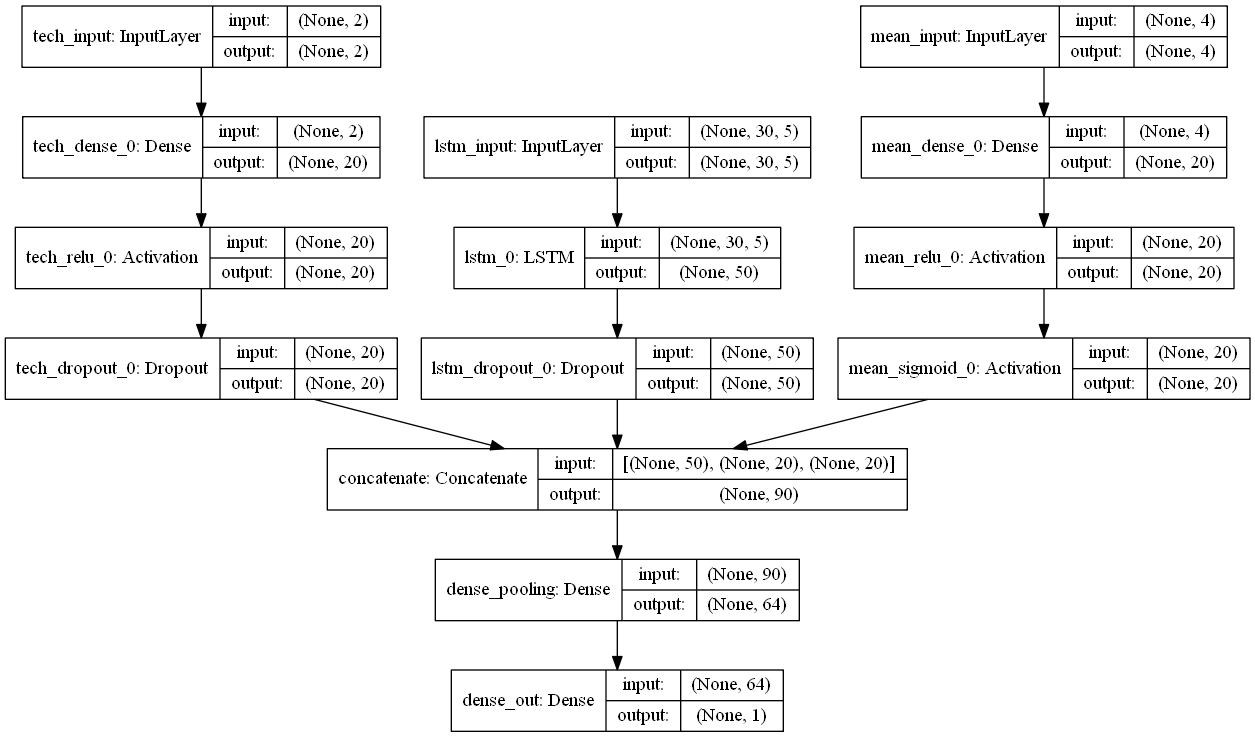

In [411]:
# Improved model including the technical indicators and average prices of past x days
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow as  tf
tf.random.set_seed(4)

# define three sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators_normalised.shape[1],), name='tech_input')
dense2_input = Input(shape=(x_day_mean_indicator.shape[1],), name='mean_input')
# lstm2_input = Input(shape=(history_points, 4), name='mean_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# the third branch opreates on the third input
y = Dense(20, name='mean_dense_0')(dense2_input)
y = Activation("relu", name='mean_relu_0')(y)
y = Activation("sigmoid", name='mean_sigmoid_0')(y)
# y = Dropout(0.2, name='mean_dropout_0')(y)
mean_branch = Model(inputs=dense2_input, outputs=y)


# combine the output of the three branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output, mean_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input, mean_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.01)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'  # path of graphviz installed (https://www.graphviz.org/)
plot_model(model, to_file='model.png', show_shapes=True)

In [412]:
# Training
# fit the model
model.fit(x=[ohlcv_train, tech_ind_train, x_day_mean_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test, x_day_mean_test], y_test)
print(evaluation)

Train on 623 samples, validate on 70 samples
Epoch 1/50
623/623 [==============================] - 1s 2ms/step - loss: 0.0867 - val_loss: 0.0090
Epoch 2/50
623/623 [==============================] - 0s 557us/step - loss: 0.0084 - val_loss: 5.5242e-05
Epoch 3/50
623/623 [==============================] - 0s 515us/step - loss: 0.0043 - val_loss: 4.8419e-04
Epoch 4/50
623/623 [==============================] - 0s 581us/step - loss: 0.0030 - val_loss: 5.8758e-04
Epoch 5/50
623/623 [==============================] - 0s 509us/step - loss: 0.0026 - val_loss: 5.7753e-04
Epoch 6/50
623/623 [==============================] - 0s 557us/step - loss: 0.0021 - val_loss: 3.2276e-05
Epoch 7/50
623/623 [==============================] - 0s 527us/step - loss: 0.0019 - val_loss: 1.7857e-04
Epoch 8/50
623/623 [==============================] - 0s 535us/step - loss: 0.0020 - val_loss: 6.3316e-04
Epoch 9/50
623/623 [==============================] - 0s 562us/step - loss: 0.0015 - val_loss: 1.6025e-05
Epoch 1

In [413]:
# print(ohlcv_train.shape)
# print(x_day_mean_train.shape)
# print(tech_ind_train.shape)

In [414]:
# Evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test, x_day_mean_test])
# model.predict returns normalised values
# now we scale them back up using the y_normaliser from before
y_test_predicted = y_open.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict([ohlcv_histories_normalised, technical_indicators_normalised, x_day_mean_indicator])
y_predicted = y_open.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


13.153489229173006


In [417]:
print(unscaled_y_test[-1])
print(y_test_predicted[-1])

[38.03]
[38.593166]


In [416]:
# import matplotlib.pyplot as plt
# plt.gcf().set_size_inches(22, 15, forward=True)

# start = 0
# end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

# plt.legend(['Real', 'Predicted'])

# plt.show()